In [ ]:
from __future__ import annotations

import io
import json
import os
import random
import re
import time
from typing import Dict, List, Any, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import requests
import seaborn as sns
from dotenv import load_dotenv

from scipy.stats import f_oneway
from sshtunnel import SSHTunnelForwarder
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from transformers import AutoTokenizer

from get_env_path import get_env_path
from mongodb import mongo
import questionnaires
from mongodb.participant_info import Gender
from system_prompts_builder import generate_all_permutations

C:\Users\stav3\anaconda3\envs\Thesis_GPTJ_Flask\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
sns.set()

load_dotenv(get_env_path())

openai.api_key = os.getenv('OPENAI_API_KEY')


TOKENIZER_GPT2 = AutoTokenizer.from_pretrained('gpt2')
URL_ADD_NEW_PARTICIPANT = 'http://127.0.0.1:5000/talk_with_ai/add_new_participant'
URL_THERAPIST_PREDICT = 'http://127.0.0.1:5000/talk_with_ai/predict'

REF = 'ChatGPT talks with meta-llama/Llama-2-13b-chat-hf miti_alexander_street #23'

ChatGPT talks with meta-llama/Llama-2-7b-chat-hf miti #14
ChatGPT talks with meta-llama/Llama-2-7b-chat-hf #15
ChatGPT talks with meta-llama/Llama-2-7b-chat-hf alexander_street_small #16
ChatGPT talks with meta-llama/Llama-2-7b-chat-hf alexander_street_large #17
ChatGPT talks with meta-llama/Llama-2-7b-chat-hf miti_alexander_street #18
ChatGPT talks with meta-llama/Llama-2-13b-chat-hf #19
ChatGPT talks with meta-llama/Llama-2-13b-chat-hf miti #20
ChatGPT talks with meta-llama/Llama-2-13b-chat-hf alexander_street_small #21
ChatGPT talks with meta-llama/Llama-2-13b-chat-hf alexander_street_large #22
ChatGPT talks with meta-llama/Llama-2-13b-chat-hf miti_alexander_street #23

In [ ]:
REMOTE_HOST_IP = str(os.getenv('CONV_GEN_REMOTE_HOST_IP'))
REMOTE_HOST_PORT = int(os.getenv('CONV_GEN_REMOTE_HOST_PORT'))
LOCAL_HOST_IP = str(os.getenv('CONV_GEN_LOCAL_HOST_IP'))
SSH_USERNAME = str(os.getenv('CONV_GEN_SSH_USERNAME'))
SSH_PASSWORD = str(os.getenv('CONV_GEN_SSH_PASSWORD'))
REMOTE_HOST_BIND_PORT = int(os.getenv('CONV_GEN_REMOTE_HOST_BIND_PORT'))

PRE_PROMPT = 'The Therapist is an expert in motivational interviewing and his goal is to motivate the Patient to' \
             ' change his or her behavior.'

In [ ]:
print(int(time.time()))

In [ ]:
_refs = [
    'ChatGPT talks with meta-llama/Llama-2-7b-chat-hf miti #14',
    'ChatGPT talks with meta-llama/Llama-2-7b-chat-hf #15',
    'ChatGPT talks with meta-llama/Llama-2-7b-chat-hf alexander_street_small #16',
    'ChatGPT talks with meta-llama/Llama-2-7b-chat-hf alexander_street_large #17',
    'ChatGPT talks with meta-llama/Llama-2-7b-chat-hf miti_alexander_street #18',
    'ChatGPT talks with meta-llama/Llama-2-13b-chat-hf #19',
    'ChatGPT talks with meta-llama/Llama-2-13b-chat-hf miti #20',
    'ChatGPT talks with meta-llama/Llama-2-13b-chat-hf alexander_street_small #21',
    'ChatGPT talks with meta-llama/Llama-2-13b-chat-hf alexander_street_large #22',
    'ChatGPT talks with meta-llama/Llama-2-13b-chat-hf miti_alexander_street #23'
]

In [ ]:
_permutations = generate_all_permutations(only_expert_therapist=True)

_seed_val = int(time.time())
_seed_val = 1706618727
print(f'Seed: {_seed_val}', f'Total permutation: {len(_permutations)}')

random.seed(_seed_val)
random.shuffle(_permutations)

In [8]:
def add_participant(gender: Gender, age: int, ref: str, model_name: str = '',
                    init_utterance: str = None, extra_info: dict = None) -> Tuple[int, int, str]:
    data = {
        'gender': gender.value,
        'reference': ref,
        'email': f'{model_name}@gmail.com',
        'age': age,
        'yoe': '',
        'is_native_en': True,
        'is_cs_expert': True,
        'is_psyc_expert': True,
        'curr_in_therapy': True,
        'been_in_therapy': True
    }

    if init_utterance is not None:
        data['init_utterance'] = init_utterance
    if extra_info is not None:
        data['extra_info'] = json.dumps(extra_info)

    response = requests.post(URL_ADD_NEW_PARTICIPANT, data=data)
    response_json = json.loads(response.content)
    return int(response_json['participant_id']), int(response_json['session_id']), response_json['utterance']


def init_window(first_utterance: str) -> List[Dict[str, Any]]:
    return [{
        'index': 1,
        'is_therapist': True,
        'utterance': first_utterance,
        'utterance_tokens_length': len(TOKENIZER_GPT2(first_utterance).input_ids)
    }]


def trim_window(window: List[Dict[str, Any]], max_tokens_count: int, last_is_therapist: bool) -> List[Dict[str, Any]]:
    tokens_count = 0
    trimmed_window = []
    for i in range(len(window) - 1, -1, -1):
        if i == len(window) - 1:
            if window[i]['is_therapist'] == last_is_therapist:
                trimmed_window.append((window[i] | {}))
                tokens_count += window[i]['utterance_tokens_length']
        else:
            if tokens_count + window[i]['utterance_tokens_length'] > max_tokens_count:
                break
            trimmed_window.append((window[i] | {}))
            tokens_count += window[i]['utterance_tokens_length']

    # print('Tokens Count:', tokens_count)
    trimmed_window.reverse()
    return trimmed_window


def create_chat_completion_args(window: List[Dict[str, Any]], window_max_tokens_count: int, system_prompt: str,
                                gen_therapist_answer: bool) -> List[Dict[str, Any]]:
    trimmed_window = trim_window(
        window=window,
        max_tokens_count=window_max_tokens_count,
        last_is_therapist=not gen_therapist_answer
    )

    messages = [{
        "role": "system",
        "content": system_prompt
    }]

    for i in range(len(trimmed_window)):
        role = 'assistant' if trimmed_window[i]['is_therapist'] is gen_therapist_answer else 'user'
        messages.append({
            "role": role,
            "content": trimmed_window[i]['utterance']
        })

    return messages


def create_openai_completion_args(window: List[Dict[str, Any]], window_max_tokens_count: int,
                                  model_name: str, system_prompt: str,
                                  gen_therapist_answer: bool) -> Dict[str, Any]:
    messages = create_chat_completion_args(
        window=window,
        window_max_tokens_count=window_max_tokens_count,
        system_prompt=system_prompt,
        gen_therapist_answer=gen_therapist_answer
    )

    d = {
        'model': model_name,
        'messages': messages,
        'request_timeout': 10
    }

    return d


def send_request_chatgpt(participant_id: int, session_id: int, window: List[Dict[str, Any]],
                         system_prompt: str, gen_therapist_answer: bool, model_name: str,
                         window_max_tokens_count: int, verbose: bool = True) -> Tuple[int, int]:
    completion_args = create_openai_completion_args(
        window=window,
        window_max_tokens_count=window_max_tokens_count,
        model_name=model_name,
        system_prompt=system_prompt,
        gen_therapist_answer=gen_therapist_answer)

    response = openai.ChatCompletion.create(**completion_args)

    clone_response = (response.__dict__ | {'system_prompt': system_prompt})
    clone_response.pop('api_key')

    model_name = clone_response['_previous']['model']
    utterance = clone_response['_previous']['choices'][0]['message']['content']
    prompt_tokens = clone_response['_previous']['usage']['prompt_tokens']
    completion_tokens = clone_response['_previous']['usage']['completion_tokens']

    utt_tokens_length = len(TOKENIZER_GPT2(utterance).input_ids)

    window.append({
        'index': len(window) + 1,
        'is_therapist': gen_therapist_answer,
        'utterance': utterance,
        'utterance_tokens_length': utt_tokens_length
    })

    if verbose:
        print(f'[{"THERAPIST" if gen_therapist_answer else "PATIENT"}] {utterance}')
    mongo.add_new_utterance(
        participant_id=participant_id,
        session_id=session_id,
        model_name=model_name,
        model_utt=gen_therapist_answer,
        utt=utterance,
        extra_info=response
    )

    return prompt_tokens, completion_tokens


# noinspection SpellCheckingInspection
def send_request_llama2(participant_id: int, session_id: int, window: List[Dict[str, Any]],
                        system_prompt: str, gen_therapist_answer: bool,
                        window_max_tokens_count: int, verbose: bool = True) -> Tuple[int, int]:
    messages = create_chat_completion_args(
        window=window,
        window_max_tokens_count=window_max_tokens_count,
        system_prompt=system_prompt,
        gen_therapist_answer=gen_therapist_answer
    )

    local_host_random_port = random.randint(5000, 9999)

    server = SSHTunnelForwarder(
        (REMOTE_HOST_IP, REMOTE_HOST_PORT),
        ssh_username=SSH_USERNAME,
        ssh_password=SSH_PASSWORD,
        remote_bind_address=(LOCAL_HOST_IP, REMOTE_HOST_BIND_PORT),
        local_bind_address=(LOCAL_HOST_IP, local_host_random_port),
    )

    server.start()

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.0; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0'}
    response = requests.get(
        f'http://127.0.0.1:{local_host_random_port}/predict',
        headers=headers,
        params={"conversation": json.dumps(messages)}
    ).content

    server.stop()

    res = json.loads(response.decode("utf-8"))

    answer = res['answer']
    model_name = res['model']

    window.append({
        'index': len(window) + 1,
        'is_therapist': gen_therapist_answer,
        'utterance': answer,
        'utterance_tokens_length': len(TOKENIZER_GPT2(answer).input_ids)
    })

    if verbose:
        print(f'[{"THERAPIST" if gen_therapist_answer else "PATIENT"}] {answer}')
    mongo.add_new_utterance(
        participant_id=participant_id,
        session_id=session_id,
        model_name=model_name,
        model_utt=gen_therapist_answer,
        utt=answer,
        extra_info=response
    )

    return 0, 0


def continue_conversation(participant_id: int, session_id: int, window: List[Dict[str, Any]],
                          max_utterances_each: int, sp_patient: str, sp_therapist: str,
                          model_name: str, window_max_tokens_count: int) -> bool:
    is_session_ended = False

    prompt_tokens = 0
    completion_tokens = 0
    for i in range(max_utterances_each):
        if is_session_ended:
            break

        pt, ct = 0, 0
        for j in range(5):
            try:
                # Generate Patient Utt
                pt, ct = send_request_chatgpt(
                    participant_id=participant_id,
                    session_id=session_id,
                    window=window,
                    model_name=model_name,
                    window_max_tokens_count=window_max_tokens_count,
                    system_prompt=sp_patient,
                    gen_therapist_answer=False
                )
                break
            except Exception as ex:
                if j == 4:
                    assert False, ex
                print(ex)
                time.sleep(10)

        prompt_tokens += pt
        completion_tokens += ct

        if 'SESSION ENDED' in window[-1]['utterance'] or 'Session ended.' in window[-1]['utterance']:
            is_session_ended = True
            break

        for j in range(5):
            try:
                pt, ct = send_request_llama2(
                    participant_id=participant_id,
                    session_id=session_id,
                    window=window,
                    window_max_tokens_count=window_max_tokens_count,
                    system_prompt=sp_therapist,
                    gen_therapist_answer=True
                )
                break
            except Exception as ex:
                if j == 4:
                    assert False, ex
                print(ex)
                time.sleep(10)

        if 'SESSION ENDED' in window[-1]['utterance'] or 'Session ended.' in window[-1]['utterance']:
            is_session_ended = True
            break
        if window[-1]['utterance'].strip() in ['Thank you. Goodbye.', 'Goodbye.']:
            is_session_ended = True
            break

        prompt_tokens += pt
        completion_tokens += ct

    total_usage_tokens = prompt_tokens + completion_tokens

    print(f"""\n\nPrompt tokens: {prompt_tokens}
Completion tokens: {completion_tokens}
Total usage: {total_usage_tokens}
Cost estimation: {0.000001 * prompt_tokens + 0.0000020 * completion_tokens}$""")

    return is_session_ended


def create_conversation(participant_id: int, session_id: int, window: List[Dict[str, Any]], max_utterances_each: int,
                        sp_patient: str, sp_therapist: str, model_name: str, window_max_tokens_count: int) -> bool:
    print('Starting conversation\n----------------------------------------------------------------')
    print(f'[THERAPIST] {window[0]["utterance"]}')

    return continue_conversation(
        participant_id=participant_id,
        session_id=session_id,
        window=window,
        max_utterances_each=max_utterances_each,
        sp_patient=sp_patient,
        sp_therapist=sp_therapist,
        model_name=model_name,
        window_max_tokens_count=window_max_tokens_count
    )


def gen_conversations(gen_permutations_count: int, gen_conv_count: int, ref: str, permutations: List[Dict[str, str]],
                      max_utterances_each: int, model_name: str, window_max_tokens_count: int):
    for i in range(gen_permutations_count):
        permutation = permutations.pop(0)
        patient_gender = Gender.from_str(string=permutation['args']['patient']['gender'])
        patient_age = permutation['args']['patient']['age_value']
        for _ in range(gen_conv_count):
            participant_id, session_id, utt = add_participant(
                gender=patient_gender,
                age=patient_age,
                ref=ref,
                init_utterance=permutation['counselor_init_utterance'],
                extra_info=permutation
            )

            window = init_window(first_utterance=utt)
            is_session_ended = create_conversation(
                participant_id=participant_id,
                session_id=session_id,
                window=window,
                max_utterances_each=max_utterances_each,
                sp_patient=permutation['patient_system_prompt'],
                sp_therapist=permutation['counselor_system_prompt'],
                model_name=model_name,
                window_max_tokens_count=window_max_tokens_count
            )

            if is_session_ended:
                continue


def write_results(dir_path: str):
    for i in range(9999):
        filename = f'{dir_path}\\{i + 1}.txt'
        if not os.path.exists(filename):
            continue

        s = '################### Start Conversation ###################\n\n'

        with open(filename, 'r') as file_handle:
            result = json.load(file_handle)

            for frag in result['conversation']:

                if frag['is_therapist']:
                    prefix = '[THERAPIST] '
                else:
                    prefix = '[PATIENT] '

                s += f'{prefix}{frag["utterance"]}\n'

            perm = result['permutation']

            perm_as_txt = ''
            for k in perm.keys():
                if k == 'args':
                    for k2 in perm['args'].keys():
                        if k2 == 'patient':
                            for k3 in perm['args']['patient'].keys():
                                perm_as_txt += f"Args - {k3}: {perm['args']['patient'][k3]}\n"
                        else:
                            perm_as_txt += f"Args - {k2}: {perm['args'][k2]}\n"
                else:

                    perm_as_txt += f"{k}: {perm[k]}\n"

        s += '\n\n################### End Conversation ###################\n\n\n\n\n\n'

        with open(f'{dir_path}\\results.txt', 'a') as file_handle:
            file_handle.writelines(f'{perm_as_txt}\n\n{s}')


def evaluate_conversation(conversation: str, questionnaire: int,
                          is_therapist_male: bool) -> Dict[str, Union[Any, int]]:
    res = questionnaires.get_prompt_eval_questionnaire(questionnaire=questionnaire, conversation=conversation[:13000],
                                                       is_therapist_male=is_therapist_male)

    for i in range(5):
        try:
            print(f'Trying to evaluate, attempt number {i + 1}')
            import time
            time.sleep(20)
            response = openai.ChatCompletion.create(
                model=res['model_name'],
                messages=[
                    {
                        "role": "user",
                        "content": res['prompt']
                    }
                ],
                max_tokens=500
            )
            return {
                'prompt': res['prompt'],
                'response': response,
                'questions_count': res['questions_count']
            }
        except Exception as e:
            print(e)

    assert False, 'FAILED to evaluate.'


def flatten_dict(d: dict) -> List[Tuple[str, Any]]:
    items = []

    def flatten(item: Any, parent_key: str = ''):
        if isinstance(item, dict):
            for k, v in item.items():
                new_key = f"{parent_key}.{k}" if parent_key != '' else k
                flatten(item=v, parent_key=new_key)
        else:
            items.append((parent_key, item))

    flatten(item=d)
    return items


def compare_dict_values(dict1: dict, dict2: dict) -> bool:
    flat_dict1 = flatten_dict(d=dict1)
    flat_dict2 = flatten_dict(d=dict2)

    return sorted(flat_dict1) == sorted(flat_dict2)


def evaluate_conversations(eval_questionnaires: List[int], k: int = -1):
    row_idx, count = 0, 0
    regex_pattern = r"\d(?=\s-\s)| \d"
    for row in mongo.TABLE.find(filter={'metadata': False, 'ref': REF}):
        participant_id = row['participant_id']
        session_id = row['session_id']
        conv_questionnaires = row['questionnaires'] if 'questionnaires' in row else []
        if participant_id == 83832982566 or participant_id == 38331138681:
            continue
        print(row_idx + 1, participant_id, session_id)
        row_idx += 1

        conv = ''
        for utt in row['session']:
            conv += '[THERAPIST] ' if utt['model_utt'] else '[PATIENT] '
            conv += utt['utt'].strip() + '\n'
        conv = conv.replace('SESSION ENDED', '').strip()

        counselor_level = row['session'][0]['extra_info']['args']['counselor_level']

        already_exists = set([list(d.keys())[0] for d in conv_questionnaires])
        results = conv_questionnaires
        retries, need_to_update = 1, False
        i = 0
        while i < len(eval_questionnaires):
            questionnaire_idx = eval_questionnaires[i]
            if f'questionnaire_{questionnaire_idx}' in already_exists:
                i += 1
                continue

            response = evaluate_conversation(conversation=conv, questionnaire=questionnaire_idx,
                                             is_therapist_male=True)
            eval_res = response['response']['choices'][0]['message']['content']
            questions_count = response['questions_count']

            scores = [int(score.strip()) for score in re.findall(regex_pattern, eval_res)]

            if len(scores) != questions_count:
                msg = ('Something went wrong with the evaluation. '
                       f'{len(scores)} != {questions_count} (questionnaire = {questionnaire_idx})')
                print(msg)
                retries += 1

                assert retries != 10, 'Too many retries.'
                continue

            print(scores)
            results.append({f'questionnaire_{questionnaire_idx}': {
                'system_prompt': response['prompt'],
                'eval_response': eval_res,
                'eval_scores': scores
            }})

            need_to_update = True
            retries = 1
            i += 1

        filename = f'results\\{participant_id}_{session_id}_{counselor_level}.txt'
        with open(filename, 'w', encoding='utf-8') as file_handle:
            file_handle.writelines(conv)

        if not need_to_update:
            continue

        mongo.TABLE.update_one(filter={
            'participant_id': participant_id,
            'session_id': session_id,
            'metadata': False,
        }, update={
            '$set': {
                'questionnaires': results
            }})

        if count == k:
            break
        else:
            count += 1


def remove_existing_permutations(permutations: List[dict], ref: str):
    for row in mongo.TABLE.find(filter={'metadata': False, 'ref': ref}):
        permutation = row['session'][0]['extra_info']['args']

        for i in range(len(permutations) - 1, -1, -1):
            if compare_dict_values(dict1=permutation, dict2=permutations[i]['args']):
                # print(permutations[i]['args'])
                print(flatten_dict(d=permutation), flatten_dict(d=permutations[i]['args']))
                permutations.pop(i)

In [8]:
remove_existing_permutations(permutations=_permutations, ref=REF)

In [9]:
len(_permutations)

96

In [ ]:
gen_conversations(
    gen_permutations_count=len(_permutations),
    gen_conv_count=1,
    ref=REF,
    permutations=_permutations,
    max_utterances_each=50,
    model_name='gpt-3.5-turbo-1106',
    window_max_tokens_count=3000
)

In [11]:
for _r in _refs:
    REF = _r
    try:
        evaluate_conversations(eval_questionnaires=[13, 14])  # GPT-3.5-turbo-1106
    except:
        pass

1 56532001715 66534001630
2 59488583644 72490582758
3 92809930369 26811930773
4 75983939261 48842390823
5 79710878877 48710978911
6 65301129819 57303130968
7 99400200888 48402201258
8 63907890868 58790889217
9 81354686740 21356696670
10 92272170848 68274170645
11 82279829845 87280029826
12 88882162662 41884163181
13 97276909123 14771099861
14 96602266648 83604267659
15 72168397747 10170397579
16 54991140145 49993139337
17 62878839752 29880839870
18 71554863365 86550633242
19 69814365967 96816454468
20 46308043573 80131004479
21 2429685865 16299858385
22 28758160480 82997601646
23 77446934124 97544713414
24 53599941542 25602941534
25 4198897241 71100898782
26 5498245711 8298596711
27 47396748366 51398748416
28 1684037836 3286413150
29 86690285734 74369228646
30 32962207371 55963208291
31 66971337896 79973336237
32 71811490837 18781249212
33 46774810612 51779808899
34 51777079657 98781079374
35 86570005369 19702051973
36 50640309866 61826423169
37 68244134471 50246443558
38 57752092695 6

In [135]:
def get_data(ref: str) -> list:
    # noinspection SpellCheckingInspection
    filterr = {
        'metadata': False,
        'ref': ref,
        'questionnaires': {'$exists': True}
    }

    return [row for row in mongo.TABLE.find(filter=filterr)]


def sessions_lengths(data: List[dict]):
    res = {
        'Bad': {
            'utt_count': [],
            'utt_length': [],
            'conv_words_count_therapist': [],
            'conv_words_count_patient': []
        },
        'Mediocre': {
            'utt_count': [],
            'utt_length': [],
            'conv_words_count_therapist': [],
            'conv_words_count_patient': []
        },
        'Good': {
            'utt_count': [],
            'utt_length': [],
            'conv_words_count_therapist': [],
            'conv_words_count_patient': []
        },
    }

    for i in range(len(data)):
        level = data[i]['session'][0]['extra_info']['args']['counselor_level']

        for j in range(len(data[i]['session'])):
            if data[i]['session'][j]['utt'].strip() in ["You're welcome. See you soon.", "Goodbye.",
                                                        "You too. Take care.", 'Goodbye for now.', 'Bye.', 'Goodbye!']:
                break

        data[i]['session'] = data[i]['session'][:31]
        res[level]['utt_count'] += [len(data[i]['session'])]

        utt_lengths = list(map(lambda x: len(x['utt'].strip().split(' ')), data[i]['session']))
        res[level]['utt_length'] += [utt_lengths]
        res[level]['conv_words_count_therapist'] += [sum(utt_lengths[0::2])]
        res[level]['conv_words_count_patient'] += [sum(utt_lengths[1::2])]

    for k in res.keys():
        res[k]['utt_length_mean'] = list(map(lambda x: float(np.mean(x)), res[k]['utt_length']))

    return res

In [143]:
_ref_idx = 1
_data = get_data(ref=_refs[_ref_idx])

_sessions_lengths = sessions_lengths(data=_data)
# _sessions_lengths['Good']['conv_words_count_therapist']
# sorted(_sessions_lengths['Good']['utt_count'])
_refs[_ref_idx]

'ChatGPT talks with meta-llama/Llama-2-7b-chat-hf #15'

In [144]:
print('Averages word count per therapist personality (count per utterance)\n')

for _k in ['Bad', 'Mediocre', 'Good']:
    if _k != 'Good':
        continue
    print(_k)
    _dataframe = pd.DataFrame(_sessions_lengths[_k]['utt_length'])

    # 0::2 is for the therapist utterances
    _tmp = _dataframe.iloc[:, 0::2].mean(axis=1)
    print('Therapist:', _tmp.mean(), _tmp.std())

    # 1::2 is for the patient utterances
    _tmp = _dataframe.iloc[:, 1::2].mean(axis=1)
    print('Patient:', _tmp.mean(), _tmp.std())
    print()

print('Averages word count per therapist personality (count per conversation)\n')

for _k in ['Bad', 'Mediocre', 'Good']:
    if _k != 'Good':
        continue
    print(_k)
    print('Therapist')
    _values = _sessions_lengths[_k]['conv_words_count_therapist']
    print(round(np.mean(_values), 2), '&', round(np.std(_values), 2))

    print('Patient')
    _values = _sessions_lengths[_k]['conv_words_count_patient']
    print(round(np.mean(_values), 2), '&', round(np.std(_values), 2))

    print()

print('Averages utterance count per therapist personality\n')

for _k in ['Bad', 'Mediocre', 'Good']:
    if _k != 'Good':
        continue
    print(_k)
    print(np.mean(_sessions_lengths[_k]['utt_count']), np.std(_sessions_lengths[_k]['utt_count']))
    print()



Averages word count per therapist personality (count per utterance)

Good
Therapist: 148.41810618490305 21.13371964531298
Patient: 73.60208183020683 27.44647190268206

Averages word count per therapist personality (count per conversation)

Good
Therapist
1169.32 & 826.38
Patient
492.93 & 383.0

Averages utterance count per therapist personality

Good
14.25 9.244367654595598


In [145]:
def get_questionnaire_scores(data: List[dict], questionnaire_id: int, therapists_levels: List[str],
                             pop_questions_indices: List[int]) -> str:
    to_pop = []
    if pop_questions_indices:
        to_pop = sorted(pop_questions_indices)

    s = ''
    for i in range(len(data)):
        scores = None
        for k in therapists_levels:  # ['Bad', 'Mediocre', 'Good']
            level = data[i]['session'][0]['extra_info']['args']['counselor_level']
            if k != level:
                continue

            for j in range(len(data[i]['questionnaires'])):
                q_key = f'questionnaire_{questionnaire_id}'
                if q_key in data[i]['questionnaires'][j]:
                    scores = list(data[i]['questionnaires'][j][q_key]['eval_scores'])

            for idx in to_pop[::-1]:
                scores.pop(idx)
            if scores:
                s += '\t'.join(list(map(str, [level] + scores))) + '\n'
    return s

In [146]:
_scores = get_questionnaire_scores(data=_data, questionnaire_id=13,
                                   therapists_levels=['Bad', 'Mediocre', 'Good'], pop_questions_indices=[])
print(_scores)

Good	4	4	3	4	3
Good	3	3	2	3	2
Good	5	5	4	4	4
Good	4	4	3	3	4
Good	5	5	5	5	5
Good	5	5	4	5	5
Good	4	5	5	5	5
Good	4	4	5	4	4
Good	4	4	5	4	5
Good	4	5	4	5	5
Good	3	2	2	2	2
Good	3	3	3	3	3
Good	5	4	5	4	4
Good	3	4	3	3	3
Good	2	2	3	2	2
Good	4	4	3	3	3
Good	1	1	1	1	1
Good	3	2	2	2	2
Good	4	3	3	4	4
Good	4	5	4	5	5
Good	5	5	5	5	5
Good	4	5	5	5	5
Good	5	5	5	5	5
Good	4	4	5	4	5
Good	2	2	3	3	3
Good	4	4	4	4	4
Good	3	3	2	3	3
Good	4	4	3	4	3
Good	4	5	5	5	5
Good	4	4	4	5	4
Good	1	1	1	1	1
Good	3	4	4	4	5
Good	4	4	3	5	4
Good	3	3	4	2	2
Good	3	2	2	1	1
Good	2	3	2	3	2
Good	4	4	4	4	5
Good	5	5	5	5	5
Good	1	2	2	1	1
Good	4	4	4	4	4
Good	3	4	4	4	3
Good	4	4	4	4	4
Good	4	4	5	4	5
Good	4	4	5	5	5
Good	4	5	4	5	5
Good	4	5	3	4	4
Good	4	5	5	5	5
Good	3	3	3	3	3
Good	2	1	1	1	1
Good	4	4	3	4	3
Good	5	5	5	5	5
Good	4	5	5	4	4
Good	4	4	4	4	4
Good	3	2	2	2	2
Good	5	5	5	5	5
Good	4	4	3	4	3
Good	3	3	2	2	2
Good	2	2	2	2	2
Good	4	4	3	4	4
Good	4	4	3	4	4
Good	5	5	5	5	5
Good	4	5	4	4	5
Good	4	4	3	4	3
Good	4	5	4	4	4
Good	4	5	5	4	4
Good	2	1	1	2	1
Good	4	4	3

In [147]:
_scores = get_questionnaire_scores(data=_data, questionnaire_id=14,
                                   therapists_levels=['Bad', 'Mediocre', 'Good'], pop_questions_indices=[])
print(_scores)

Good	4	4	4	4	4	4	5	4	4	5	4	5	5	5	5	5	5	4	4
Good	3	4	3	4	4	4	3	3	4	5	3	4	4	3	5	4	4	3	4
Good	4	5	3	4	5	5	5	5	5	5	3	5	5	4	5	5	4	4	5
Good	5	5	4	4	5	5	5	5	5	5	4	5	5	4	5	5	4	4	5
Good	4	5	4	5	5	5	5	4	5	5	5	5	5	5	5	5	5	4	1
Good	4	5	4	4	5	4	5	4	4	5	3	5	5	4	5	4	5	4	4
Good	4	4	3	3	4	3	4	4	4	5	3	4	4	3	5	4	4	3	4
Good	4	3	4	4	5	4	3	4	4	5	3	4	4	4	5	5	4	4	4
Good	5	4	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5
Good	4	5	4	5	5	5	4	4	5	5	3	5	5	5	5	5	4	4	1
Good	2	2	1	1	1	1	3	3	1	5	1	3	3	3	5	3	2	2	1
Good	4	4	3	4	4	4	4	4	4	5	3	4	4	4	5	4	4	4	4
Good	4	5	5	5	5	5	5	5	4	5	5	5	5	5	5	5	5	5	2
Good	4	5	3	4	5	5	5	5	5	5	3	5	5	4	5	5	5	3	3
Good	4	3	2	3	3	3	3	3	2	5	2	5	4	4	5	4	3	2	3
Good	4	4	4	4	5	4	5	5	4	5	4	5	5	5	5	4	5	4	1
Good	4	3	5	4	4	4	4	5	3	5	3	4	4	5	5	4	5	3	2
Good	3	4	4	4	4	4	3	4	3	5	3	3	3	3	5	4	4	3	2
Good	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5	1
Good	4	5	3	5	5	5	4	4	4	5	3	5	5	4	5	5	5	4	5
Good	4	5	4	4	5	5	5	4	5	5	4	5	5	5	5	5	5	4	5
Good	4	5	4	5	5	5	4	4	5	5	3	4	4	5	5	5	5	4	1
Good	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5	5
Good	4	5	3	

In [139]:
_df = pd.read_csv(io.StringIO(_scores), sep='\t', header=None)
_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Good,5,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1,Good,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,1
2,Good,3,4,3,4,4,4,3,4,3,5,3,4,4,3,5,4,4,3,3
3,Good,3,4,4,4,3,4,3,3,3,4,3,3,3,3,4,3,4,3,2
4,Good,4,4,3,3,4,4,4,3,4,5,3,4,4,3,5,4,4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Good,3,3,2,3,3,4,4,3,3,5,2,3,4,3,5,4,4,3,2
92,Good,5,5,4,4,5,5,5,5,5,5,4,5,5,5,5,5,5,4,5
93,Good,4,5,5,5,5,5,5,5,5,5,4,5,5,4,5,5,5,4,5
94,Good,4,4,4,5,4,4,3,3,3,5,4,4,4,4,5,5,4,3,3


In [140]:
def plot_means_errors(data: List[dict], questionnaire_id: int,
                      pop_questions_indices: List[int], fig_title: str):
    scores = get_questionnaire_scores(data=data, questionnaire_id=questionnaire_id,
                                      therapists_levels=['Bad', 'Mediocre', 'Good'],
                                      pop_questions_indices=pop_questions_indices)
    df = pd.read_csv(io.StringIO(scores), sep='\t', header=None)
    df.rename(columns={df.columns[0]: 'Condition'}, inplace=True)
    df['Mean Value'] = df.iloc[:, 1:].mean(axis=1)

    mapping = {'Bad': 'Poor', 'Mediocre': 'Average', 'Good': 'Expert'}
    df['Condition'] = df['Condition'].apply(lambda x: mapping[x])

    grouped = df.groupby('Condition')['Mean Value']
    means = grouped.mean()
    errors = grouped.sem()

    conditions_order = ['Poor', 'Average', 'Expert']
    means = means.reindex(conditions_order)
    errors = errors.reindex(conditions_order)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(bottom=0.15, top=0.95, left=0.09, right=0.97)  # Increase the bottom margin

    means.plot(kind='bar', yerr=errors, capsize=5)
    plt.ylabel('Mean response value (1-5)', fontsize=20)
    plt.yticks(fontsize=16)

    plt.xlabel('Therapist skill', fontsize=20)
    plt.xticks(rotation=0, fontsize=16)

    # plt.title(fig_title, fontsize=24, color='salmon', weight='bold')

    # Show the plot
    plt.savefig(f'fig_{fig_title.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

In [28]:
sns.set_style("whitegrid")

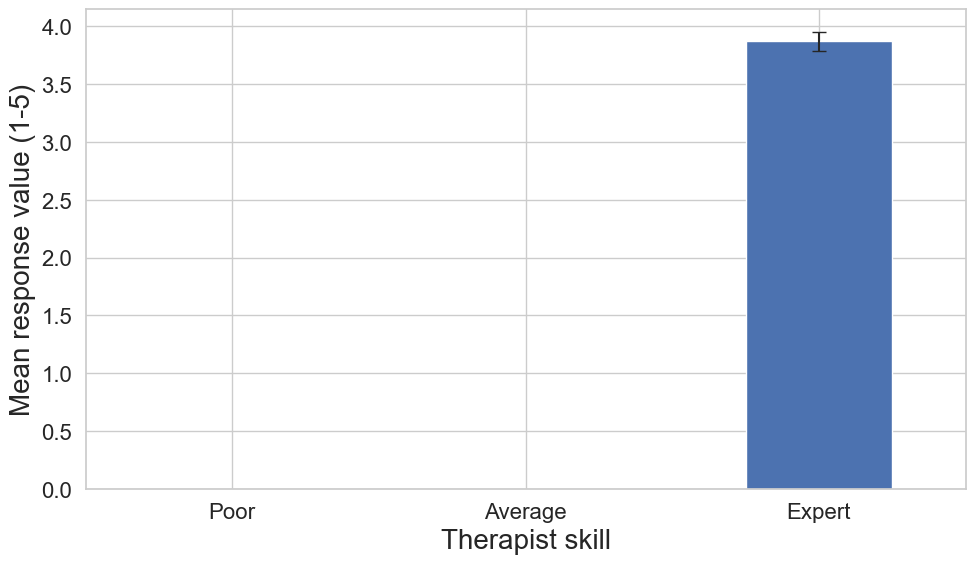

In [29]:
plot_means_errors(data=_data, questionnaire_id=13, pop_questions_indices=[], fig_title='Questionnaire 1')

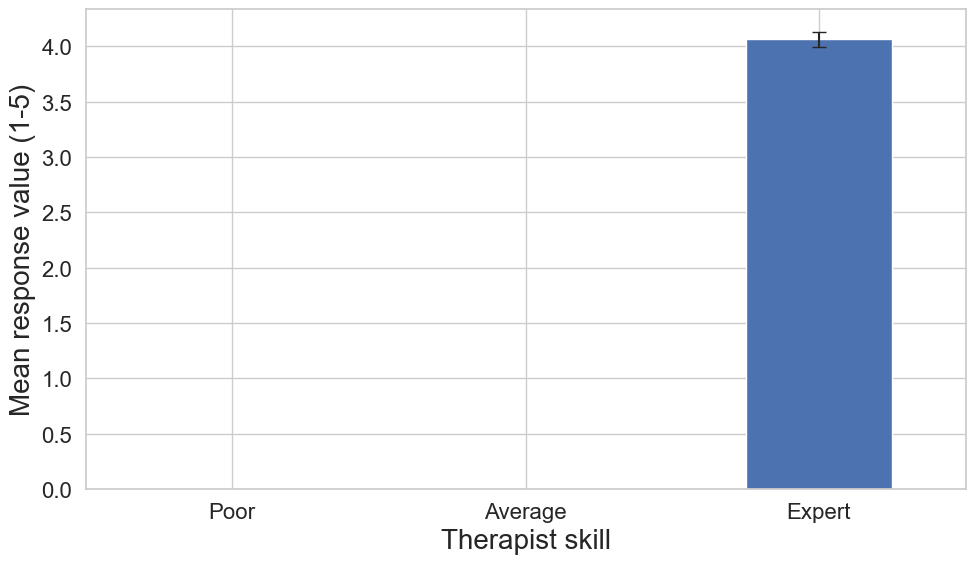

In [30]:
plot_means_errors(data=_data, questionnaire_id=14, pop_questions_indices=[14, 18], fig_title='Questionnaire 2')

In [31]:
def calculate_anova(data: List[dict], questionnaire_id: int, pop_questions_indices: List[int]):
    scores = get_questionnaire_scores(data=data, questionnaire_id=questionnaire_id,
                                      therapists_levels=['Bad', 'Mediocre', 'Good'],
                                      pop_questions_indices=pop_questions_indices)
    df = pd.read_csv(io.StringIO(scores), sep='\t', header=None)
    df.rename(columns={df.columns[0]: 'Condition'}, inplace=True)
    df['Mean Value'] = df.iloc[:, 1:].mean(axis=1)

    # Perform One-Way ANOVA
    anova_result = f_oneway(df[df['Condition'] == 'Bad']['Mean Value'],
                            df[df['Condition'] == 'Mediocre']['Mean Value'],
                            df[df['Condition'] == 'Good']['Mean Value'])
    print(f"ANOVA Result:\n{anova_result}\n")

    # If ANOVA is significant, perform post hoc test
    if anova_result.pvalue < 0.05:
        # Prepare data for Tukey's HSD test
        tukey_data = df[['Condition', 'Mean Value']]
        tukey_test = pairwise_tukeyhsd(endog=tukey_data['Mean Value'], groups=tukey_data['Condition'], alpha=0.05)

        print("Tukey's HSD Test Result:")
        print(tukey_test)

In [32]:
calculate_anova(data=_data, questionnaire_id=13, pop_questions_indices=[])

ANOVA Result:
F_onewayResult(statistic=nan, pvalue=nan)


C:\Users\stav3\anaconda3\envs\Thesis_GPTJ_Flask\lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [33]:
calculate_anova(data=_data, questionnaire_id=14, pop_questions_indices=[14, 18])

ANOVA Result:
F_onewayResult(statistic=nan, pvalue=nan)


C:\Users\stav3\anaconda3\envs\Thesis_GPTJ_Flask\lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [34]:
def calculate_anova_conv_length(session_length: Dict[str, Dict[str, List[int]]]):
    key = 'utt_count'

    condition = ['Bad'] * len(session_length['Bad'][key]) + \
                ['Mediocre'] * len(session_length['Mediocre'][key]) + \
                ['Good'] * len(session_length['Good'][key])

    df = pd.DataFrame({
        'Condition': condition,
        'Values': session_length['Bad'][key] + \
                  session_length['Mediocre'][key] + \
                  session_length['Good'][key]
    })

    # Perform One-Way ANOVA
    anova_result = f_oneway(df[df['Condition'] == 'Bad']['Values'],
                            df[df['Condition'] == 'Mediocre']['Values'],
                            df[df['Condition'] == 'Good']['Values'])
    print(f"ANOVA Result:\n{anova_result}\n")

    # If ANOVA is significant, perform post hoc test
    if anova_result.pvalue < 0.05:
        # Prepare data for Tukey's HSD test
        tukey_data = df[['Condition', 'Values']]
        tukey_test = pairwise_tukeyhsd(endog=tukey_data['Values'], groups=tukey_data['Condition'], alpha=0.05)

        print("Tukey's HSD Test Result:")
        print(tukey_test)

In [35]:
calculate_anova_conv_length(session_length=_sessions_lengths)

ANOVA Result:
F_onewayResult(statistic=nan, pvalue=nan)


C:\Users\stav3\anaconda3\envs\Thesis_GPTJ_Flask\lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [36]:
def calculate_anova_words_count(session_length: Dict[str, Dict[str, List[int]]], is_therapist: bool):
    key = 'conv_words_count_therapist' if is_therapist else 'conv_words_count_patient'

    if is_therapist:
        print('Therapist:')
    else:
        print('Patient:')
    print()

    condition = ['Bad'] * len(session_length['Bad'][key]) + \
                ['Mediocre'] * len(session_length['Mediocre'][key]) + \
                ['Good'] * len(session_length['Good'][key])

    df = pd.DataFrame({
        'Condition': condition,
        'Values': session_length['Bad'][key] + \
                  session_length['Mediocre'][key] + \
                  session_length['Good'][key]
    })

    # Perform One-Way ANOVA
    anova_result = f_oneway(df[df['Condition'] == 'Bad']['Values'],
                            df[df['Condition'] == 'Mediocre']['Values'],
                            df[df['Condition'] == 'Good']['Values'])
    print(f"ANOVA Result:\n{anova_result}\n")

    # If ANOVA is significant, perform post hoc test
    if anova_result.pvalue < 0.05:
        # Prepare data for Tukey's HSD test
        tukey_data = df[['Condition', 'Values']]
        tukey_test = pairwise_tukeyhsd(endog=tukey_data['Values'], groups=tukey_data['Condition'], alpha=0.05)

        print("Tukey's HSD Test Result:")
        print(tukey_test)

In [37]:
calculate_anova_words_count(session_length=_sessions_lengths, is_therapist=True)

Therapist:

ANOVA Result:
F_onewayResult(statistic=nan, pvalue=nan)


C:\Users\stav3\anaconda3\envs\Thesis_GPTJ_Flask\lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [38]:
calculate_anova_words_count(session_length=_sessions_lengths, is_therapist=False)

Patient:

ANOVA Result:
F_onewayResult(statistic=nan, pvalue=nan)


C:\Users\stav3\anaconda3\envs\Thesis_GPTJ_Flask\lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [39]:
_s = """2.614583333	1.625	1.15625	1.416666667	1.96875	1.447916667	1.979166667	1.53125	1.53125	1.125	2.260416667	2.239583333	1.322916667	1.552083333	1.364583333	1.25	1.125
3.1875	2.510416667	1.989583333	2.447916667	2.927083333	2.427083333	2.697916667	2.385416667	2.572916667	1.864583333	3.104166667	3.1875	2.177083333	2.625	2.395833333	2.40625	2.0625
4.333333333	4.875	4.427083333	4.729166667	4.895833333	4.90625	4.78125	4.791666667	4.802083333	4.395833333	4.927083333	4.927083333	4.770833333	4.9375	4.916666667	4.90625	4.53125""".replace(
    '\t', ',')

In [40]:
print(_s)

2.614583333,1.625,1.15625,1.416666667,1.96875,1.447916667,1.979166667,1.53125,1.53125,1.125,2.260416667,2.239583333,1.322916667,1.552083333,1.364583333,1.25,1.125
3.1875,2.510416667,1.989583333,2.447916667,2.927083333,2.427083333,2.697916667,2.385416667,2.572916667,1.864583333,3.104166667,3.1875,2.177083333,2.625,2.395833333,2.40625,2.0625
4.333333333,4.875,4.427083333,4.729166667,4.895833333,4.90625,4.78125,4.791666667,4.802083333,4.395833333,4.927083333,4.927083333,4.770833333,4.9375,4.916666667,4.90625,4.53125


In [ ]:
_df = pd.read_csv(io.StringIO(_s), header=None).round(2)
_df.columns += 1
print(_df.T.to_string().replace('  ', ' & '))

Q1 &  2.61 & 3.19 & 4.33 \\
Q2 &  1.62 & 2.51 & 4.88 \\
Q3 &  1.16 & 1.99 & 4.43 \\
Q4 &  1.42 & 2.45 & 4.73 \\
Q5 &  1.97 & 2.93 & 4.90 \\
Q6 &  1.45 & 2.43 & 4.91 \\
Q7 &  1.98 & 2.70 & 4.78 \\
Q8 &  1.53 & 2.39 & 4.79 \\
Q9 &  1.53 & 2.57 & 4.80 \\
Q10 & 1.12 & 1.86 & 4.40 \\
Q11 & 2.26 & 3.10 & 4.93 \\
Q12 & 2.24 & 3.19 & 4.93 \\
Q13 & 1.32 & 2.18 & 4.77 \\
Q14 & 1.55 & 2.62 & 4.94 \\
Q15 & 1.36 & 2.40 & 4.92 \\
Q16 & 1.25 & 2.41 & 4.91 \\
Q17 & 1.12 & 2.06 & 4.53 \\


In [ ]:
_s = """3.34375	2.3125	1.75	2.052083333	2.635416667	2.15625	2.78125	2.40625	2.34375	2.229166667	1.708333333	3.15625	3.15625	2.010416667	2.333333333	2.197916667	1.739583333
3.458333333	2.885416667	2.260416667	2.84375	3.333333333	2.916666667	3.145833333	2.90625	2.916666667	3.21875	2.21875	3.510416667	3.489583333	2.677083333	3	3.041666667	2.458333333
4.302083333	4.770833333	4.34375	4.78125	4.875	4.875	4.78125	4.760416667	4.75	5	4.1875	4.927083333	4.9375	4.645833333	4.895833333	4.90625	4.458333333""".replace(
    '\t', ',')

_df = pd.read_csv(io.StringIO(_s), header=None).round(2)
_df.columns += 1
print(_df.T.to_string().replace('  ', ' & '))

 &  &  &  0 &  &  1 &  &  2
Q1 &  3.34 & 3.46 & 4.30 \\
Q2 &  2.31 & 2.89 & 4.77 \\
Q3 &  1.75 & 2.26 & 4.34 \\
Q4 &  2.05 & 2.84 & 4.78 \\
Q5 &  2.64 & 3.33 & 4.88 \\
Q6 &  2.16 & 2.92 & 4.88 \\
Q7 &  2.78 & 3.15 & 4.78 \\
Q8 &  2.41 & 2.91 & 4.76 \\
Q9 &  2.34 & 2.92 & 4.75 \\
Q10 & 2.23 & 3.22 & 5.00 \\
Q11 & 1.71 & 2.22 & 4.19 \\
Q12 & 3.16 & 3.51 & 4.93 \\
Q13 & 3.16 & 3.49 & 4.94 \\
Q14 & 2.01 & 2.68 & 4.65 \\
Q15 & 2.33 & 3.00 & 4.90 \\
Q16 & 2.20 & 3.04 & 4.91 \\
Q17 & 1.74 & 2.46 & 4.46 \\


In [ ]:
# noinspection SpellCheckingInspection
_filterr = {
    'metadata': False,
    # 'survey_completed': False,
    'ref': REF,
    'questionnaires': {'$exists': True}
}

_total_prompt_tokens, _total_completion_tokens = 0, 0
for _row in mongo.TABLE.find(filter=_filterr):
    for _i in range(len(_row['session'])):
        if 'usage' not in _row['session'][_i]['extra_info']:
            continue
        _total_prompt_tokens += _row['session'][_i]['extra_info']['usage']['prompt_tokens']
        _total_completion_tokens += _row['session'][_i]['extra_info']['usage']['completion_tokens']

# break

_total_prompt_tokens, _total_completion_tokens

In [ ]:
_total_prompt_tokens * 0.001 / 1000, _total_completion_tokens * 0.002 / 1000

In [ ]:
_total_prompt_tokens * 0.001 / 1000 + _total_completion_tokens * 0.002 / 1000

Cost per 1K input tokens: 0.001$
Cost per 1K output tokens: 0.002$

-------- Cost --------
Input tokens: 3728729, cost: 3.73$
Output tokens: 309323, cost: 0.62$ 
Total cost: 4.35$

In [ ]:
# noinspection SpellCheckingInspection
_filterr = {
    'metadata': False,
    # 'survey_completed': False,
    'ref': REF,
    'questionnaires': {'$exists': True}
}

_total_prompt_tokens, _total_completion_tokens = 0, 0
for _row in mongo.TABLE.find(filter=_filterr):
    for _i in range(2):
        _sp = _row['questionnaires'][_i][f'questionnaire_{_i + 1}']['system_prompt']
        _response = _row['questionnaires'][_i][f'questionnaire_{_i + 1}']['eval_response']
        _total_prompt_tokens += len(TOKENIZER_GPT2(_sp).input_ids)
        _total_completion_tokens += len(TOKENIZER_GPT2(_response).input_ids)

_total_prompt_tokens, _total_completion_tokens

In [ ]:
_total_prompt_tokens * 0.001 / 1000, _total_completion_tokens * 0.002 / 1000

In [ ]:
_total_prompt_tokens * 0.001 / 1000 + _total_completion_tokens * 0.002 / 1000

Cost per 1K input tokens: 0.001$
Cost per 1K output tokens: 0.002$

-------- Cost --------
Input tokens: 1309622, cost: 1.31$
Output tokens: 140028, cost: 0.28$ 
Total cost: 1.59$

63557069517	94796094726	Mediocre	SV_43onJ1bd5Dhj5ga	https://idc.az1.qualtrics.com/jfe/form/SV_43onJ1bd5Dhj5ga	
82630693786	46864858680	Mediocre	SV_aVMxKRqFeKjxdvU	https://idc.az1.qualtrics.com/jfe/form/SV_aVMxKRqFeKjxdvU	
69571522291	60805995274	Good	SV_eo0F6akFRYggVUy	https://idc.az1.qualtrics.com/jfe/form/SV_eo0F6akFRYggVUy	
51608704844	19841638383	Mediocre	SV_3INN9qzmMm5iyEu	https://idc.az1.qualtrics.com/jfe/form/SV_3INN9qzmMm5iyEu	
75352767778	28586303761	Bad	SV_0JuHylKxvTBj8O2	https://idc.az1.qualtrics.com/jfe/form/SV_0JuHylKxvTBj8O2	
40612506662	69685152537	Good	SV_aWubkz9Wy7rGz7o	https://idc.az1.qualtrics.com/jfe/form/SV_aWubkz9Wy7rGz7o	
43684402911	4274568547	Good	SV_0dCI0zepl6Vok0S	https://idc.az1.qualtrics.com/jfe/form/SV_0dCI0zepl6Vok0S	
26487804261	90726835786	Bad	SV_8pLMUvigGUBD1Ii	https://idc.az1.qualtrics.com/jfe/form/SV_8pLMUvigGUBD1Ii	
65643609557	34875620198	Good	SV_0ul4iqrEs62kihM	https://idc.az1.qualtrics.com/jfe/form/SV_0ul4iqrEs62kihM	
42132436833	96366170642	Good	SV_085qfhVlJxUw8Bw	https://idc.az1.qualtrics.com/jfe/form/SV_085qfhVlJxUw8Bw	
73887002240	46126813776	Bad	SV_9uDNECoiALsdPtc	https://idc.az1.qualtrics.com/jfe/form/SV_9uDNECoiALsdPtc	
6977196367	786085928	Bad	SV_2lU8kVHoVc531T8	https://idc.az1.qualtrics.com/jfe/form/SV_2lU8kVHoVc531T8	
90548303657	35781932888	Bad	SV_0DIzo2TYPjn5rpQ	https://idc.az1.qualtrics.com/jfe/form/SV_0DIzo2TYPjn5rpQ	
54545870898	45577928478	Good	SV_6PuqUQAzeNG4yXA	https://idc.az1.qualtrics.com/jfe/form/SV_6PuqUQAzeNG4yXA	
57284446228	63515405428	Mediocre	SV_7P9UrSgMh10t8B8	https://idc.az1.qualtrics.com/jfe/form/SV_7P9UrSgMh10t8B8	
53242755162	39661332486	Mediocre	SV_0xqK8bl2tI9x8km	https://idc.az1.qualtrics.com/jfe/form/SV_0xqK8bl2tI9x8km	
16558673436	52796603293	Good	SV_86ofDXUeWfIb0OO	https://idc.az1.qualtrics.com/jfe/form/SV_86ofDXUeWfIb0OO	
17282177730	80551152574	Mediocre	SV_1zSIVIHWOgXqYkK	https://idc.az1.qualtrics.com/jfe/form/SV_1zSIVIHWOgXqYkK	
63616634466	87847230233	Mediocre	SV_aXjLYiNN9BjwVBI	https://idc.az1.qualtrics.com/jfe/form/SV_aXjLYiNN9BjwVBI	
50636228394	66888827631	Mediocre	SV_3CnPvtTdUPR7Xdc	https://idc.az1.qualtrics.com/jfe/form/SV_3CnPvtTdUPR7Xdc	
4035355315	34275474573	Good	SV_1TXwzOEIxiaTHnM	https://idc.az1.qualtrics.com/jfe/form/SV_1TXwzOEIxiaTHnM	
69827861559	2660926767	Bad	SV_bOElVa8Hymh1AqO	https://idc.az1.qualtrics.com/jfe/form/SV_bOElVa8Hymh1AqO	
25664895585	27903876881	Mediocre	SV_2t2rwm6Rpb8p9S6	https://idc.az1.qualtrics.com/jfe/form/SV_2t2rwm6Rpb8p9S6	
50397034820	90421142612	Bad	SV_0iaqUZj6nDK3F4i	https://idc.az1.qualtrics.com/jfe/form/SV_0iaqUZj6nDK3F4i	
92979009624	93210115715	Bad	SV_4MXiuZeSW2RvshM	https://idc.az1.qualtrics.com/jfe/form/SV_4MXiuZeSW2RvshM	
42653567720	25770361797	Mediocre	SV_5sFfCgGMx67bqqa	https://idc.az1.qualtrics.com/jfe/form/SV_5sFfCgGMx67bqqa	
83842393239	4375199655	Good	SV_aW8xz36qPDD6HHw	https://idc.az1.qualtrics.com/jfe/form/SV_aW8xz36qPDD6HHw	
78425398372	85657751364	Good	SV_e3A72wvWqJqhYuG	https://idc.az1.qualtrics.com/jfe/form/SV_e3A72wvWqJqhYuG	
74655259415	86889485146	Bad	SV_e3EiHuq0pRcNAJ8	https://idc.az1.qualtrics.com/jfe/form/SV_e3EiHuq0pRcNAJ8	
45257651649	5394987478	Bad	SV_0GtBIBwUpChC8EC	https://idc.az1.qualtrics.com/jfe/form/SV_0GtBIBwUpChC8EC	